# IMPORT LIBRARIES

In [1]:
import sys
import random
import re
import numpy as np
import os
import collections
import torch
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from PIL import Image
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

from SIBI_classifier.logger.logging import log_manager
from SIBI_classifier.utils.main_utils import custom_title_print
from SIBI_classifier.configuration.configuration import ConfigurationManager
from SIBI_classifier.exception import SIBIClassificationException

# SETUP CONSTANTS
In this section, we will define some constants that are important for data processing and model training.
These constants will help us set the dataset folder path, the extension pattern of the image files to be collected, and which folders to access.
Later, these constants will be used in various parts of the code.

In [2]:
CONFIG = ConfigurationManager()
DATA_PREPROCESSING_CONFIG = CONFIG.get_data_preprocessing_config()
DATA_INGESTION_CONFIG = CONFIG.get_data_ingestion_config()
LOGGER = log_manager.setup_logger("DataPreprocessingLogger")
COLLECT_AND_COMBINE_IMAGES_LOGGER = log_manager.setup_logger("collect_and_combine_images_logger")
FILE_PATH_INFO_LOGGER = log_manager.setup_logger("file_path_info_logger")
SPLIT_TRAIN_VALID_TEST_LOGGER = log_manager.setup_logger("split_train_valid_test_logger")
CLASS_DISTRIBUTION_LOGGER = log_manager.setup_logger("class_distribution_logger")
DATASET_INSPECT_LOGGER = log_manager.setup_logger("dataset_inspect_logger")
COLOR_TEXT = "yellow"

np.random.seed(DATA_PREPROCESSING_CONFIG.seed)
random.seed(DATA_PREPROCESSING_CONFIG.seed)
torch.manual_seed(DATA_PREPROCESSING_CONFIG.seed)

[ 2024-11-30 00:27:35 ] create_directories_logger - INFO - created directory at: artifacts
[ 2024-11-30 00:27:35 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/data_preprocessing/objects
[ 2024-11-30 00:27:35 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/data_ingestion/SIBI_dataset


# PREPARING DATA WORKFLOW

## Load Data From Folders

### function

In [3]:
def collect_images_with_regex_and_count(
        path, 
        folder_classes, 
        extensions_pattern
    ):
    """
    Collects images from specified directories that match a given file extension pattern.

    Args:
        path (str): The root directory path containing the folder classes.
        folder_classes (list): List of folder names representing different classes.
        extensions_pattern (str): Regex pattern to match file extensions.

    Returns:
        dict: A dictionary where keys are folder classes and values are lists of image paths.
    """
    try:
        # Initialize a dictionary to hold image paths for each class
        image_paths = {folder_class: [] for folder_class in folder_classes}
        
        # Compile the regex pattern for matching file extensions
        pattern = re.compile(str(extensions_pattern), re.IGNORECASE)

        # Iterate over each class folder
        for folder_class in folder_classes:
            folder_path = Path(path) / folder_class

            # Recursively search for files matching the pattern in each class folder
            for file_path in folder_path.rglob("*"):
                if pattern.search(file_path.suffix):
                    image_paths[folder_class].append(file_path)

            COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"Collecting from class {log_manager.color_text(folder_class, COLOR_TEXT)}: {log_manager.color_text(len(image_paths[folder_class]), COLOR_TEXT)} paths found.")

        return image_paths

    except Exception as e:
        # Handle exceptions and return an empty dictionary if no classes are retrieved
        COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"No classes are retrieved from directory.")
        return {}

In [4]:
def get_random_images(
        image_paths, 
        num_samples, 
        seed=42
    ):
    """
    Retrieves a random number of images from the image path list.
    Args:
        image_paths (list): A list of image paths.
        num_samples (int): The number of images to retrieve. If None, all images will be selected.
        seed (int): Seed to control the random retrieval results so that the results can be reproduced. Default is 42.
    Returns:
        list: A list of randomly selected image paths.
    """

    try:
        random.seed(seed)
        return random.sample(image_paths, min(len(image_paths) if num_samples is None else num_samples, len(image_paths)))

    except Exception as e:
        raise SIBIClassificationException(e, sys)

In [5]:
def collect_and_combine_images(
        classes, 
        train_path=None, 
        valid_path=None,
        test_path=None, 
        pattern_regex=r"\.(jpe?g)$", 
        num_images_per_class=None, 
        seed=42
    ):
    """
    Collects and merges images from the training and validation folders, and retrieves a random number of images from each class.
    Args:
        classes (list): List of classes (folder names) to process.
        train_path (str): The main path of the training folder that contains image data sub-folders.
        valid_path (str): The main path of the validation folder that contains the image data sub-folders.
        pattern_regex (str): The regex pattern for matching image file extensions (e.g. r'\.(jpg|png|jpeg)$').
        num_images_per_class (dict): Dictionary containing the number of images to fetch for each class. If None, all images will be retrieved.
        seed (int): Seed for random image retrieval. Default is 42.
    Returns:
        list: A combined list of image paths from the training and validation folders that were randomly picked.
    """

    try:
        def process_class(cls):
            # Combine images from training and validation for each class
            all_train_images = train_images_paths.get(cls, [])
            all_valid_images = valid_images_paths.get(cls, [])
            all_test_images = test_images_paths.get(cls, [])
            all_combined_images = all_train_images + all_valid_images + all_test_images

            # Retrieve a random number of images from the combined image
            return get_random_images(
                image_paths=all_combined_images,
                num_samples=None if num_images_per_class is None else num_images_per_class.get(cls, len(all_combined_images)),
                seed=seed
            )

        custom_title_print(f"COLLECT {classes} FROM TRAINING DATA")
        train_images_paths = collect_images_with_regex_and_count(train_path, classes, pattern_regex)
        custom_title_print(f"=")

        # Print the title for the image collection process of the validation data
        custom_title_print(f"COLLECT {classes} FROM VALIDATION DATA")
        valid_images_paths = collect_images_with_regex_and_count(valid_path, classes, pattern_regex)
        custom_title_print(f"=")

        # Print the title for the image collection process of the test data
        custom_title_print(f"COLLECT {classes} FROM TEST DATA")
        test_images_paths = collect_images_with_regex_and_count(test_path, classes, pattern_regex)
        custom_title_print(f"=")

        # Print titles for the process of merging images from training and validation
        custom_title_print(f"COMBINING {classes} FROM TRAINING AND VALIDATION DATA")

        random_images = {}

        # Using ThreadPoolExecutor to speed up the process of fetching images from each class in parallel
        with ThreadPoolExecutor() as executor:
            results = executor.map(process_class, classes)

        # Store the random image results for each class into the dictionary
        for cls, images in zip(classes, results):
            random_images[cls] = images
            COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"Total {log_manager.color_text(cls, 'yellow')} taken: {log_manager.color_text(len(random_images[cls]), 'yellow')}")

        # Merge all image paths from all classes
        all_images_paths = sum(random_images.values(), [])
        all_images_paths = [str(path) for path in all_images_paths]
        custom_title_print(f"Total images taken: {len(all_images_paths)}")

        return all_images_paths

    except Exception as e:
        raise SIBIClassificationException(e, sys)

### main program

In [6]:
LOGGER.info("Collecting and combining images from training and validation folders...")

all_images_paths = collect_and_combine_images(
    classes = DATA_PREPROCESSING_CONFIG.label_list,
    train_path  = DATA_INGESTION_CONFIG.data_download_store_train_dir_path,
    pattern_regex = DATA_PREPROCESSING_CONFIG.image_extension_regex,
    seed= DATA_PREPROCESSING_CONFIG.seed
)

[ 2024-11-30 00:27:35 ] DataPreprocessingLogger - INFO - Collecting and combining images from training and validation folders...
[ 2024-11-30 00:27:35 ] title_print_logger - INFO - COLLECT ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] FROM TRAINING DATA
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class A: 200 paths found.
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class B: 200 paths found.
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class C: 200 paths found.
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class D: 200 paths found.
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class E: 200 paths found.
[ 2024-11-30 00:27:35 ] collect_and_combine_images_logger - INFO - Collecting from class F: 200 paths found.
[ 2024-

## Display file paths info

### function

In [7]:
class FilePathInfo:
    """
    The FilePathInfo class is used to display detailed information about file paths on a dataset, including
    file name, extension, file size, and label (if any). This class also supports the use of different
    size units such as 'bytes', 'kb', 'mb', and 'gb'.
    Args:
        unit_file_size (str, optional): The unit to display the file size ('bytes', 'kb', 'mb', 'gb'). Default is 'bytes'.
    """

    def __init__(
            self, 
            unit_file_size='bytes'
        ):

        """
        Initialize the FilePathInfo class with the given file size unit.
        Args:
            unit_file_size (str, optional): The unit to display the file size ('bytes', 'kb', 'mb', 'gb'). Default is 'bytes'.
        """
        self.unit_file_size = unit_file_size.lower()
        self.units = ['bytes', 'kb', 'mb', 'gb']
        if self.unit_file_size not in self.units:
            raise ValueError(f"Invalid unit. Choose from {self.units}.")

    def show_train_files_path_info(
            self, 
            files_path_data, 
            is_random=False
        ):

        """
        Display detailed information about file paths in the training dataset.
        Args:
            files_path_data(tf.data.Dataset): The dataset containing the file paths.
            is_labeled (bool, optional): Indicates whether the dataset has a label. Default is True.
            is_random (bool, optional): Indicates whether the dataset needs to be randomized before displaying. Default is False.
        Returns:
            int: The label index on the file path, if the dataset has a label.
        """

        files_path_data_plot = random.choice(files_path_data) if is_random else files_path_data[0]
        label_index = self._display_path_info(files_path_data_plot, is_labeled=True)
        return label_index

    def show_test_files_path_info(
            self, 
            files_path_data, 
            is_random=False
        ):

        """
        Display detailed information about file paths in the testing dataset.
        Args:
            files_path_data(tf.data.Dataset): The dataset containing the file paths.
            is_random (bool, optional): Indicates whether the dataset needs to be randomized before display. Default is False.
        """

        files_path_data_plot = random.choice(files_path_data) if is_random else files_path_data[0]
        self._display_path_info(files_path_data_plot, is_labeled=False)

    def _display_path_info(
            self, 
            file_path, 
            is_labeled
        ):

        """
        Displays the full information of the selected file path, including the file name, extension, size, and label if any.
        Args:
            files_path_data_plot(tf.data.Dataset): A subset of the dataset to be displayed.
            is_labeled (bool): Indicates whether the dataset has a label.
        Returns:
            int: The label index on the file path if the dataset is labeled.
        """
        custom_title_print(' PATH INFO ')
        FILE_PATH_INFO_LOGGER.info(f'File Path: {log_manager.color_text(file_path, COLOR_TEXT)}')

        split_file_path = file_path.split(os.path.sep)
        self._display_split_file_path(split_file_path)

        if is_labeled:
            kind_data = split_file_path[-3]
            index_label = self._display_kind_data_info(split_file_path, kind_data)
            self._display_file_info(split_file_path, file_path)
            return index_label
        else:
            self._display_file_info(split_file_path, file_path)

    def _display_split_file_path(
            self, 
            split_file_path
        ):

        """
        Displays the path of the split file and the index of each section.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
        """
        custom_title_print(' SPLIT FILE PATH ')
        FILE_PATH_INFO_LOGGER.info(f'Split File Path: {log_manager.color_text(split_file_path, COLOR_TEXT)}')

        custom_title_print(' INDEXED PATH ')
        result = {value: f'Index -> {index}' for index, value in enumerate(split_file_path)}
        for key, value in result.items():
            FILE_PATH_INFO_LOGGER.info(f'{log_manager.color_text(value, COLOR_TEXT)}: {log_manager.color_text(key, COLOR_TEXT)}')

    def _display_kind_data_info(
            self, 
            split_file_path, 
            kind_data
        ):

        """
        Displays the index and label of the data based on its type.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
            kind_data (str): The type of data in the file path.
        Returns:
            int: The index of the label in the file path.
        """
        custom_title_print(f' KIND DATA INDEX {kind_data} ')
        index = split_file_path.index(kind_data)
        FILE_PATH_INFO_LOGGER.info(f'Index of "{log_manager.color_text(kind_data, COLOR_TEXT)}": {log_manager.color_text(index, COLOR_TEXT)}')

        index_label = index + 1
        custom_title_print(' INDEX LABEL ')
        FILE_PATH_INFO_LOGGER.info(f'Index Label: {log_manager.color_text(index_label, COLOR_TEXT)}')

        custom_title_print(' LABEL ')
        FILE_PATH_INFO_LOGGER.info(f'Label: {log_manager.color_text(split_file_path[index_label], COLOR_TEXT)}')

        return index_label

    def _display_file_info(
            self, 
            split_file_path, 
            file_path
        ):

        """
        Displays detailed information about the file such as name, extension, and file size.
        Args:
            split_file_path(tf.Tensor): The path of the split file.
            file_path (tf.Tensor): The path of the file.
        """
        file_name = split_file_path[-1]
        custom_title_print(' FILE NAME ')
        FILE_PATH_INFO_LOGGER.info(f'File Name: {log_manager.color_text(file_name, COLOR_TEXT)}')

        file_extension = os.path.splitext(file_name)[1]
        custom_title_print(' FILE EXTENSION ')
        FILE_PATH_INFO_LOGGER.info(f'File Extension: {log_manager.color_text(file_extension, COLOR_TEXT)}')

        image_size = Image.open(file_path).size
        custom_title_print(' IMAGE SIZE (PX)')
        FILE_PATH_INFO_LOGGER.info(f'Image Size: width={log_manager.color_text(image_size[0], COLOR_TEXT)}, height={log_manager.color_text(image_size[1], COLOR_TEXT)}')

        file_size = os.path.getsize(file_path)
        file_size = self._format_file_size(file_size)
        custom_title_print(' FILE SIZE ')
        FILE_PATH_INFO_LOGGER.info(f'File Size: {log_manager.color_text(file_size, COLOR_TEXT)} {log_manager.color_text(self.unit_file_size, COLOR_TEXT)}')


    def _format_file_size(
            self, 
            size
        ):
        
        """
        Formats the file size according to the selected unit.
        Args:
            size (int): File size in bytes.
        Returns:
            str: The size of the formatted file.
        """

        match self.unit_file_size:
            case 'bytes':
                size = size
            case 'kb':
                size /= 1024
            case 'mb':
                size /= 1024 ** 2
            case 'gb':
                size /= 1024 ** 3
            case _:
                raise ValueError(f"Invalid unit. Choose from {self.units}.")
        
        size = round(size, 4)

        return size

In [8]:
print(f'first data: {all_images_paths[0]}')
print(f'number of data: {len(all_images_paths)}')

first data: artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/A/image_A_(1723068087.4824092).jpg
number of data: 5200


In [9]:
file_info  = FilePathInfo(unit_file_size='kb')

In [10]:
LABEL_INDEX = file_info.show_train_files_path_info(all_images_paths, is_random=True)

[ 2024-11-30 00:27:36 ] title_print_logger - INFO - =================== PATH INFO ====================
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - File Path: artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/W/image_W_(1723083370.198182).jpg
[ 2024-11-30 00:27:36 ] title_print_logger - INFO - ================ SPLIT FILE PATH =================
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - Split File Path: ['artifacts', '<model_name>', 'data_ingestion', 'SIBI_dataset', 'Train', 'W', 'image_W_(1723083370.198182).jpg']
[ 2024-11-30 00:27:36 ] title_print_logger - INFO - ================== INDEXED PATH ==================
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - Index -> 0: artifacts
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - Index -> 1: <model_name>
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - Index -> 2: data_ingestion
[ 2024-11-30 00:27:36 ] file_path_info_logger - INFO - Index -> 3: SIBI_dataset
[ 2024-11-30 00:27:36 ] file_p

## Convert to Pytorch Dataset

### function

In [11]:
class ImageDataset(Dataset):
    def __init__(self, file_paths, label_index):
        """
        Dataset for a list of image files.
        :param file_paths: List paths to images.
        """
        self.file_paths = file_paths
        self.label_index = label_index

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        split_text = self.file_paths[idx].split(os.path.sep)
        label = split_text[self.label_index]
        return self.file_paths[idx], label

### main program

In [12]:
pytorch_paths = ImageDataset(all_images_paths, LABEL_INDEX)

In [13]:
pytorch_paths[0]

('artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/A/image_A_(1723068087.4824092).jpg',
 'A')

## Split Data

### function

In [14]:
class DatasetSplitter:
    def __init__(self):
        pass

    def split_train_valid_test(self, dataset, split_ratio=None, shuffle=True, seed=42):
        if split_ratio is None or len(split_ratio) < 2:
            raise ValueError("split_ratio must be of the form (train_ratio, val_ratio).")

        train_ratio, val_ratio = split_ratio
        test_ratio = max(1.0 - (train_ratio + val_ratio), 0)

        total_ratio = round(sum((train_ratio, val_ratio, test_ratio)), 2)
        if total_ratio != 1.0:
            raise ValueError("[ERROR] split_ratio must sum to 1.0.")

        dataset_size = len(dataset)
        labels = [data[1] for data in dataset]  # Assuming dataset[i] = (data, label)

        # Stratified split for train and remaining (val + test)
        train_idx, temp_idx, _, temp_labels = train_test_split(
            list(range(dataset_size)),
            labels,
            test_size=(val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else None,
            stratify=labels if labels else None,
            random_state=seed,
        )

        if test_ratio > 0:  # If test_ratio > 0, perform stratified split for val and test
            val_size_ratio = val_ratio / (val_ratio + test_ratio)
            val_idx, test_idx, _, _ = train_test_split(
                temp_idx,
                temp_labels,
                test_size=(1 - val_size_ratio),
                stratify=temp_labels if temp_labels else None,
                random_state=seed,
            )
        else:  # If test_ratio == 0, assign all remaining data to validation
            val_idx = temp_idx
            test_idx = []

        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)
        test_dataset = Subset(dataset, test_idx)

        self._display_info(
            dataset_size=dataset_size,
            train_dataset=train_dataset,
            valid_dataset=val_dataset,
            test_dataset=test_dataset,
            shuffle=shuffle,
        )

        return train_dataset, val_dataset, test_dataset

    def _display_info(self, dataset_size, train_dataset, valid_dataset, test_dataset, shuffle):
        """
        Displays information about the split dataset.
        """
        train_ratio = len(train_dataset) / dataset_size
        valid_ratio = len(valid_dataset) / dataset_size
        test_ratio = len(test_dataset) / dataset_size

        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Total number of data: {log_manager.color_text(dataset_size, COLOR_TEXT)}")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Shuffle status: {log_manager.color_text(shuffle, COLOR_TEXT)}")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Training Dataset: {log_manager.color_text(len(train_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{train_ratio * 100:.2f}%', COLOR_TEXT)})")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Validation Dataset: {log_manager.color_text(len(valid_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{valid_ratio * 100:.2f}%', COLOR_TEXT)})")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Test Dataset: {log_manager.color_text(len(test_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{test_ratio * 100:.2f}%', COLOR_TEXT)})")

### main program

In [15]:
splitter = DatasetSplitter()

In [16]:
train_pt_paths, val_pt_paths, _ = splitter.split_train_valid_test(
    pytorch_paths, 
    split_ratio=(0.8, 0.2),
    shuffle=True,
    seed=42
)

[ 2024-11-30 00:27:36 ] split_train_valid_test_logger - INFO - Total number of data: 5200
[ 2024-11-30 00:27:36 ] split_train_valid_test_logger - INFO - Shuffle status: True
[ 2024-11-30 00:27:36 ] split_train_valid_test_logger - INFO - Training Dataset: 4160 (80.00%)
[ 2024-11-30 00:27:36 ] split_train_valid_test_logger - INFO - Validation Dataset: 1040 (20.00%)
[ 2024-11-30 00:27:36 ] split_train_valid_test_logger - INFO - Test Dataset: 0 (0.00%)


## Class Distribution

### function

In [17]:
def calculate_class_distribution_torch(
        dataset=None, 
        class_labels=None
    ) -> tuple:
    """
    Menghitung distribusi kelas dan class weights untuk dataset PyTorch.

    :param dataset: Dataset PyTorch (torch.utils.data.Dataset atau torch.utils.data.Subset)
    :param class_labels: Daftar label kelas (list).
    :return: Tuple (class_counts, class_weights).
    """
    try:
        # Mengambil semua label dari dataset
        class_names = [data[1] for data in dataset]
        
        # Hitung jumlah tiap kelas
        class_counts = Counter(class_names)

        # Konversi ke indeks berdasarkan urutan class_labels
        class_indices = [class_labels.index(name) for name in class_names]

        # Hitung class weights menggunakan sklearn
        class_weight_values = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(class_indices),
            y=class_indices
        )

        # Buat dictionary untuk class weights
        class_weights = {i: weight for i, weight in enumerate(class_weight_values)}

        return class_counts, class_weights

    except Exception as e:
        raise SIBIClassificationException(e, sys)

In [18]:
def print_class_distribution(
        distribution: collections.Counter=None
    ) -> None:

    """
    Prints the class distribution to the screen.
    Args:
        distribution(collections.Counter): A Counter object containing the class distribution.
    """
    try:
        for class_name, count in sorted(distribution.items()):
            CLASS_DISTRIBUTION_LOGGER.info(f"class {log_manager.color_text(class_name, COLOR_TEXT)}: {log_manager.color_text(count, COLOR_TEXT)} items")

    except Exception as e:
        raise SIBIClassificationException(e, sys)

### main program

In [19]:
train_class_distribution, class_weights = calculate_class_distribution_torch(
    dataset=train_pt_paths, 
    class_labels=DATA_PREPROCESSING_CONFIG.label_list
)

In [20]:
valid_class_distribution, _ = calculate_class_distribution_torch(
    dataset=val_pt_paths, 
    class_labels=DATA_PREPROCESSING_CONFIG.label_list
)

In [21]:
custom_title_print("Class distribution on Train set:")
print_class_distribution(train_class_distribution)

custom_title_print("Class distribution in Validation set:")
print_class_distribution(valid_class_distribution)

[ 2024-11-30 00:27:36 ] title_print_logger - INFO - =========CLASS DISTRIBUTION ON TRAIN SET:=========
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class A: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class B: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class C: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class D: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class E: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class F: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class G: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class H: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class I: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class J: 160 items
[ 2024-11-30 00:27:36 ] class_distribution_logger - INFO - class K: 160 items
[ 2024-11-30 00:27:36 ] class_distribut

## Data Augmentation

### function

In [22]:
class ImageProcessor:
    def __init__(
            self, 
            image_size,
            brightness,
            contrast,
            saturation,
            hue,
            p
        ):

        self.image_size = image_size
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.p = p

    def image_resizing(self):
        return  transforms.Resize(
            size=self.image_size[:2],
            interpolation=transforms.InterpolationMode.BILINEAR
        )

    def color_jitter(self):
        return transforms.ColorJitter(
            brightness=self.brightness, 
            contrast=self.contrast, 
            saturation=self.saturation, 
            hue=self.hue
        )

    def hFlip(self):
        return transforms.RandomHorizontalFlip(p=self.p)

    def vFlip(self):
        return transforms.RandomVerticalFlip(p=self.p)

In [23]:
class ConvertPathsToTensor(Dataset):
    def __init__(self, datasets, label_list, seed, transform=None):
        """
        Dataset for a list of image files.
        """
        self.datasets = datasets
        self.transform = transform
        self.label_list = label_list
        self.seed = seed

    def __len__(self):
        return len(self.datasets)

    def __getitem__(self, idx):
        file_path, label = self.datasets[idx]
        image = torchvision.io.read_image(file_path) / 255.
        label_to_index = torch.tensor(self.label_list.index(label))

        if self.transform is not None:
            torch.manual_seed(self.seed)
            image = self.transform(image)
            image = torch.clip(image, min=0.0, max=1.0)

        image = image.to(torch.float32)
        label_to_index = label_to_index.to(torch.int32)
        return image, label_to_index

In [24]:
def calculate_fig_layout(num_features, subplot_figsize):
    num_subplots = len(num_features)
    num_rows = int(np.sqrt(num_subplots))
    num_cols = int(np.ceil(num_subplots / num_rows))
    fig_size = (num_cols * subplot_figsize[0], num_rows * subplot_figsize[1])
    plt.figure(figsize=fig_size)
    return num_rows, num_cols

### main program

In [25]:
# Read the image from computer
# input_img = Image.open('./artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/Z/image_Z_(1723083821.1149957).jpg')

# # Define interpolation methods and their names
# interpolation_methods = {
#     "Nearest Exact Interpolation": transforms.InterpolationMode.NEAREST_EXACT,
#     "Nearest Interpolation": transforms.InterpolationMode.NEAREST,
#     "Lanczos Interpolation": transforms.InterpolationMode.LANCZOS,
#     "Hamming Interpolation": transforms.InterpolationMode.HAMMING,
#     "Box Interpolation": transforms.InterpolationMode.BOX,
#     "Bilinear Interpolation": transforms.InterpolationMode.BILINEAR,
#     "Bicubic Interpolation": transforms.InterpolationMode.BICUBIC,
# }


# # Resize images using different interpolation methods
# resize_transforms = {
#     title: transforms.Resize(size=[300, 300], interpolation=interp, antialias=True)
#     for title, interp in interpolation_methods.items()
# }

# # Apply transformations and store outputs
# output_imgs = {title: resize(input_img) for title, resize in resize_transforms.items()}

# # Plot results
# num_rows, num_cols = calculate_fig_layout(interpolation_methods, subplot_figsize=(8, 8))

# for i, (title, img) in enumerate(output_imgs.items(), start=1):
#     plt.subplot(num_rows, num_cols, i)
#     plt.imshow(img)
#     plt.title(title)
#     plt.axis('off')

# plt.show()

In [26]:
image_processor = ImageProcessor(
    image_size=DATA_PREPROCESSING_CONFIG.img_size[:2],
    brightness=DATA_PREPROCESSING_CONFIG.brightness, 
    contrast=DATA_PREPROCESSING_CONFIG.contrast,
    saturation=DATA_PREPROCESSING_CONFIG.saturation,
    hue=DATA_PREPROCESSING_CONFIG.hue,
    p=DATA_PREPROCESSING_CONFIG.p,
)

In [27]:
train_transforms = transforms.Compose([
    image_processor.image_resizing(),
    image_processor.color_jitter(),
    image_processor.hFlip(),
    image_processor.vFlip(),
])

valid_transforms = transforms.Compose([
    image_processor.image_resizing(),
])

In [28]:
train_pt_datasets = ConvertPathsToTensor(
    datasets=train_pt_paths,
    label_list=DATA_PREPROCESSING_CONFIG.label_list,
    seed=DATA_PREPROCESSING_CONFIG.seed,
    transform=train_transforms
)

valid_pt_datasets = ConvertPathsToTensor(
    datasets=val_pt_paths,
    label_list=DATA_PREPROCESSING_CONFIG.label_list,
    seed=DATA_PREPROCESSING_CONFIG.seed,
    transform=valid_transforms
)

## Inspecting the dataset

### function

In [34]:
class DataInspector:
    def __init__(self, label_list, figsize):
        self.label_list = label_list
        self.figsize = figsize

    def _inspect_single_dataset(self, dataset, dataset_name, idx):
        get_idx = random.randint(0, len(dataset)) if idx == None else idx
        image, label = dataset[get_idx]
        self._print_data_info(f"{dataset_name}_data info", image, label)
        self._plot_images(dataset_name, image, label)

    def _print_data_info(self, title, image, label):
        custom_title_print(title)
        DATASET_INSPECT_LOGGER.info(f'shape-image: {log_manager.color_text(image.shape, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'dtype-image: {log_manager.color_text(image.dtype, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'max-intensity: {log_manager.color_text(image.max(), COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'min-intensity: {log_manager.color_text(image.min(), COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label: {log_manager.color_text(label, COLOR_TEXT)} -> {log_manager.color_text(self.label_list[label], COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label-shape: {log_manager.color_text(label.shape, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label-type: {log_manager.color_text(label.dtype, COLOR_TEXT)}')

    def _plot_images(self, dataset_name, image, label):
        plt.figure(figsize=self.figsize)
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.title(f'{dataset_name.capitalize()} Label: {self.label_list[label]}')
        plt.axis("off")
        plt.show()

    def inspect(self, idx=None, **datasets):
        for dataset_name, dataset in datasets.items():
            self._inspect_single_dataset(dataset, dataset_name, idx)

In [35]:
inspector = DataInspector(
    label_list = DATA_PREPROCESSING_CONFIG.label_list,
    figsize = (12,6)
)

[ 2024-11-30 00:31:26 ] title_print_logger - INFO - =============TRAIN_DATASET_DATA INFO==============
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - shape-image: torch.Size([3, 224, 224])
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - dtype-image: torch.float32
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - max-intensity: 0.931575357913971
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - min-intensity: 0.15826159715652466
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label: 21 -> V
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label-shape: torch.Size([])


[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label-type: torch.int32


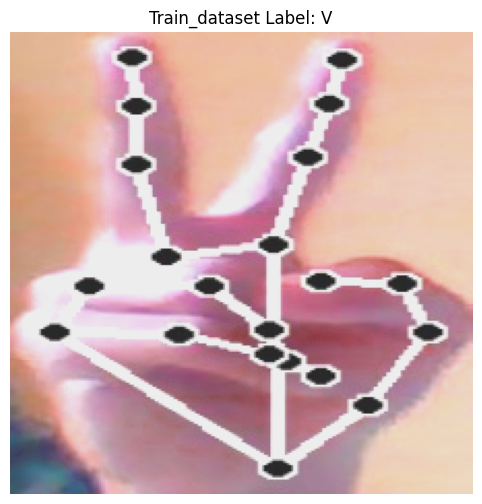

[ 2024-11-30 00:31:26 ] title_print_logger - INFO - =============VALID_DATASET_DATA INFO==============
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - shape-image: torch.Size([3, 224, 224])
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - dtype-image: torch.float32
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - max-intensity: 1.0
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - min-intensity: 0.0
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label: 22 -> W
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label-shape: torch.Size([])
[ 2024-11-30 00:31:26 ] dataset_inspect_logger - INFO - label-type: torch.int32


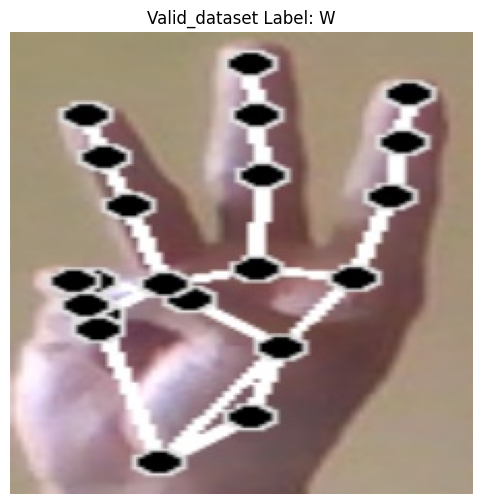

In [37]:
inspector.inspect(
    train_dataset=train_pt_datasets,
    valid_dataset=valid_pt_datasets,
)

In [32]:
log_manager.clean_log_file()